In [32]:
# import necessary Python packages to download the data set
import os
import zipfile
import sys
import pandas as pd
import numpy as np
# adjust the format of the data set
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)

In [33]:
def load_data(data_dir):
    """Load the GEFCom 2014 energy load data"""

    energy = pd.read_csv(os.path.join(data_dir, 'energy.csv'), parse_dates=['timestamp'])

    # Reindex the dataframe such that the dataframe has a record for every time point
    # between the minimum and maximum timestamp in the time series. This helps to 
    # identify missing time periods in the data (there are none in this dataset).

    energy.index = energy['timestamp']
    energy = energy.reindex(pd.date_range(min(energy['timestamp']),
                                          max(energy['timestamp']),
                                          freq='H'))
    energy = energy.drop('timestamp', axis=1)

    return energy

In [41]:
# This function unzips the GEFCom2014 data zip file and extracts the 'extended'
# load forecasting competition data. Data is saved in energy.csv
def extract_data(data_dir):
    GEFCom_dir = os.path.join(data_dir, 'GEFCom2014', 'GEFCom2014 Data')

    GEFCom_zipfile = os.path.join(data_dir, 'GEFCom2014.zip')
    if not os.path.exists(GEFCom_zipfile):
        sys.exit("Download GEFCom2014.zip from https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip?dl=0 and save it to the '{}' directory.".format(data_dir))

    # unzip root directory
    zip_ref = zipfile.ZipFile(GEFCom_zipfile, 'r')
    zip_ref.extractall(os.path.join(data_dir, 'GEFCom2014'))
    zip_ref.close()

    # extract the extended competition data
    zip_ref = zipfile.ZipFile(os.path.join(GEFCom_dir, 'GEFCom2014-E_V2.zip'), 'r')
    zip_ref.extractall(os.path.join(data_dir, 'GEFCom2014-E'))
    zip_ref.close()

    # load the data from Excel file
    data = pd.read_excel(os.path.join(data_dir, 'GEFCom2014-E', 'GEFCom2014-E.xlsx'), parse_dates=['Date'])

    # create timestamp variable from Date and Hour
    data['timestamp'] = data['Date'].add(pd.to_timedelta(data.Hour - 1, unit='h'))
    data = data[['timestamp', 'load', 'T']]
    data = data.rename(columns={'T':'temp'})

    # remove time period with no load data
    data = data[data.timestamp >= '2012-01-01']

    # save to csv
    data.to_csv(os.path.join(data_dir, 'energy.csv'), index=False)

In [42]:
data_dir = 'E:\datasets\energy'

In [43]:
extract_data(data_dir)

In [44]:
ts_data_load = load_data(data_dir)[['load']]
ts_data_load.head()

,load
2012-01-01 00:00:00,"2,698.00"
2012-01-01 01:00:00,"2,558.00"
2012-01-01 02:00:00,"2,444.00"
2012-01-01 03:00:00,"2,402.00"
2012-01-01 04:00:00,"2,403.00"


In [45]:
ts_data_load.index

DatetimeIndex(['2012-01-01 00:00:00', '2012-01-01 01:00:00',
               '2012-01-01 02:00:00', '2012-01-01 03:00:00',
               '2012-01-01 04:00:00', '2012-01-01 05:00:00',
               '2012-01-01 06:00:00', '2012-01-01 07:00:00',
               '2012-01-01 08:00:00', '2012-01-01 09:00:00',
               ...
               '2014-12-31 14:00:00', '2014-12-31 15:00:00',
               '2014-12-31 16:00:00', '2014-12-31 17:00:00',
               '2014-12-31 18:00:00', '2014-12-31 19:00:00',
               '2014-12-31 20:00:00', '2014-12-31 21:00:00',
               '2014-12-31 22:00:00', '2014-12-31 23:00:00'],
              dtype='datetime64[ns]', length=26304, freq='H')

In [49]:
# import necessary Python packages
import statsmodels.api as sm
import warnings
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
warnings.filterwarnings("ignore")

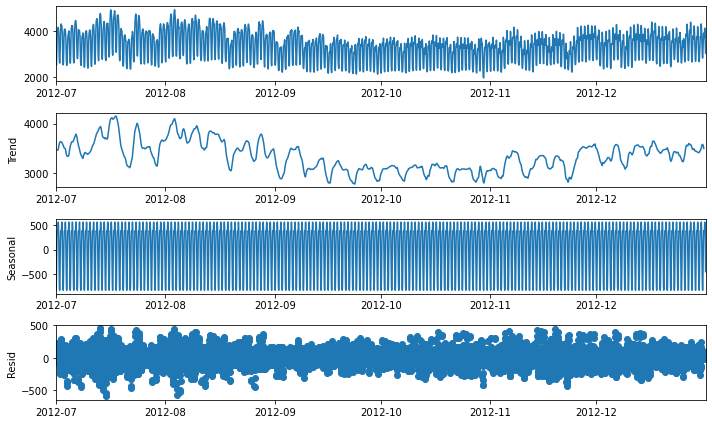

In [53]:
decomposition = sm.tsa.seasonal_decompose(ts_data_load['2012-07-01':'2012-12-31'], model = 'additive')
fig = decomposition.plot()
matplotlib.rcParams['figure.figsize'] = [20.0, 6.0]

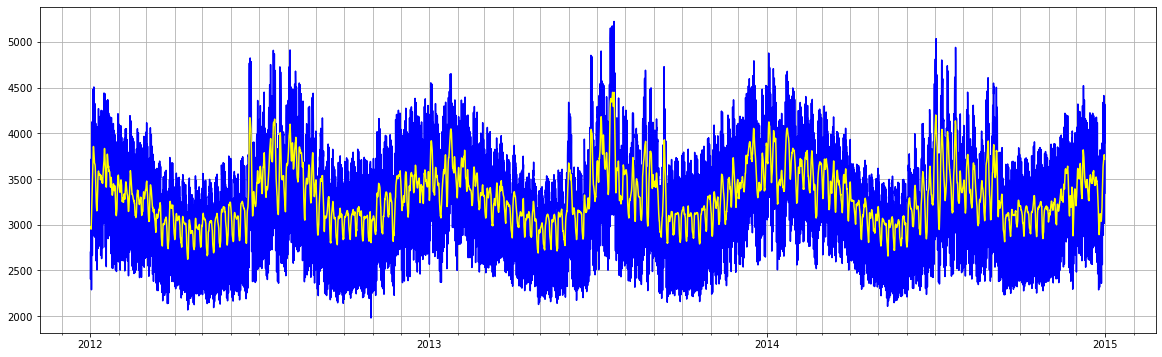

In [56]:
decomposition = sm.tsa.seasonal_decompose(ts_data_load, model = 'additive')
fig, ax = plt.subplots()
ax.grid(True)
year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=1)
year_format = mdates.DateFormatter('%Y')
month_format = mdates.DateFormatter('%m')
ax.xaxis.set_minor_locator(month)
ax.xaxis.grid(True, which = 'minor')
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(year_format)
plt.plot(ts_data_load.index, ts_data_load, c='blue')
plt.plot(decomposition.trend.index, decomposition.trend, c='yellow')

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

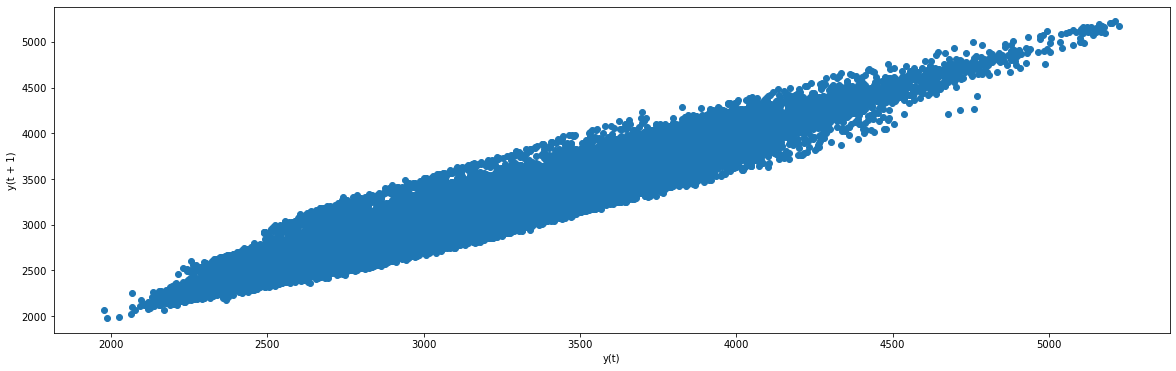

In [57]:
# Import lag_plot function
from pandas.plotting import lag_plot
plt.figure()
# Pass the lag argument and plot the values.
# When lag=1 the plot is essentially data[:-1] vs. data[1:]
# Plot our ts_data_load set
lag_plot(ts_data_load)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

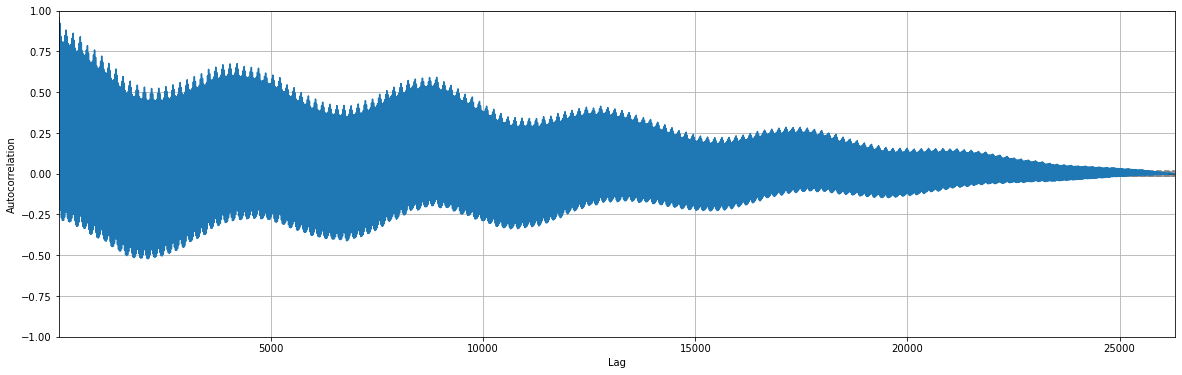

In [58]:
# Import autocorrelation_plot function
from pandas.plotting import autocorrelation_plot
plt.figure()
# Pass the autocorrelation argument and plot the values
autocorrelation_plot(ts_data_load)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

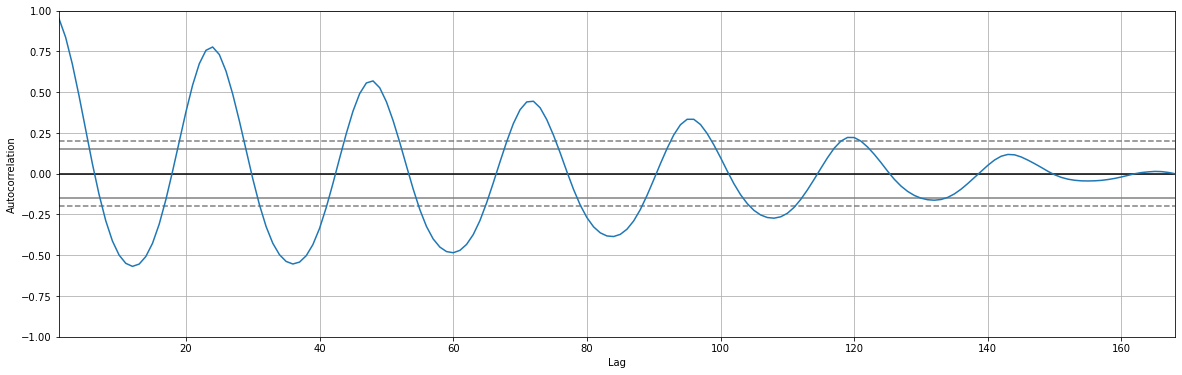

In [59]:
# Create subset
ts_data_load_subset = ts_data_load['2014-08-01':'2014-08-07']
# Import autocorrelation _plot function
from pandas.plotting import autocorrelation_plot
plt.figure()
# Pass the autocorrelation argument and plot the values
autocorrelation_plot(ts_data_load_subset)

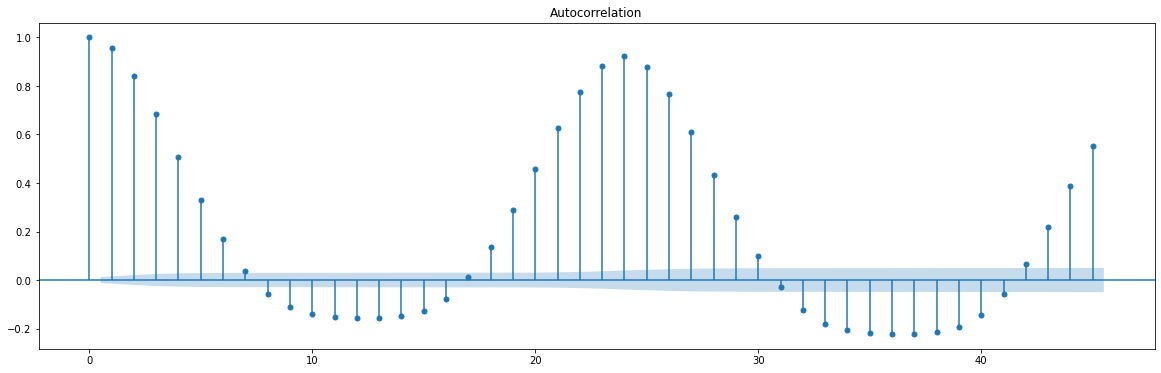

In [63]:
# Import plot_acf() function
from statsmodels.graphics.tsaplots import plot_acf
# Plot the acf function on the ts_data_load set
plot_acf(ts_data_load)
plt.show()

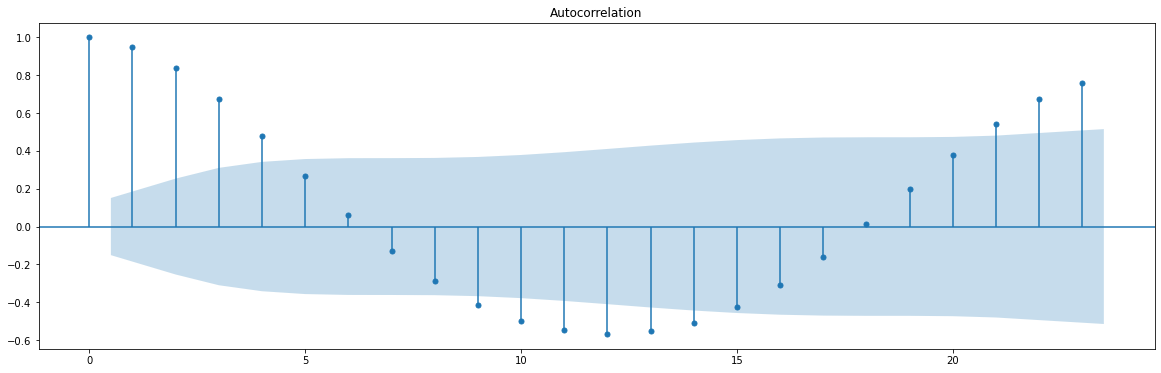

In [62]:
# Import plot_acf() function
from statsmodels.graphics.tsaplots import plot_acf
# Plot the acf function on the ts_data_load_subset
plot_acf(ts_data_load_subset)
plt.show()

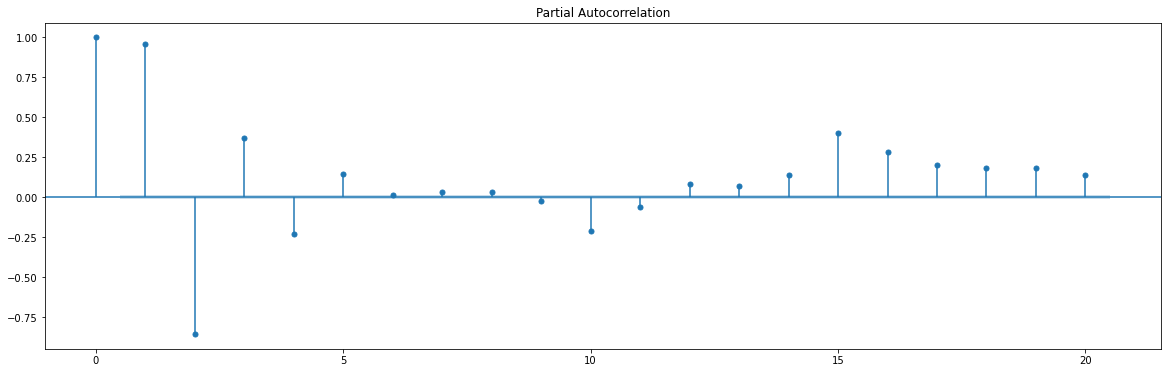

In [65]:
# Import plot_pacf() function
from statsmodels.graphics.tsaplots import plot_pacf
# Plot the pacf function on the ts_data_load dataset
plot_pacf(ts_data_load, lags=20)
plt.show()

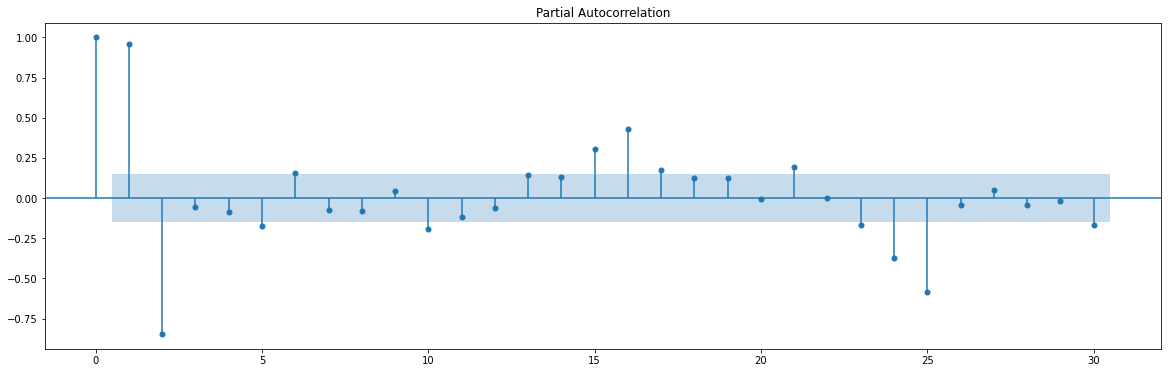

In [66]:
# import plot_pacf() function
from statsmodels.graphics.tsaplots import plot_pacf
# plot the pacf function on the ts_data_load_subset
plot_pacf(ts_data_load_subset, lags=30)
plt.show()

In [69]:
#Import necessary libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
# Apply AutoReg model
model = AutoReg(ts_data_load, 1)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                   load   No. Observations:                26304
Model:                     AutoReg(1)   Log Likelihood             -171639.978
Method:               Conditional MLE   S.D. of innovations            165.100
Date:                Wed, 17 Feb 2021   AIC                             10.213
Time:                        21:04:40   BIC                             10.214
Sample:                    01-01-2012   HQIC                            10.214
                         - 12-31-2014                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    144.5181      6.043     23.913      0.000     132.673     156.363
load.L1        0.9563      0.002    530.344      0.000       0.953       0.960
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0457           +0.0000j            1.0457            0.0000
-----------------------------------------------------------------------------
"""

No handles with labels found to put in legend.


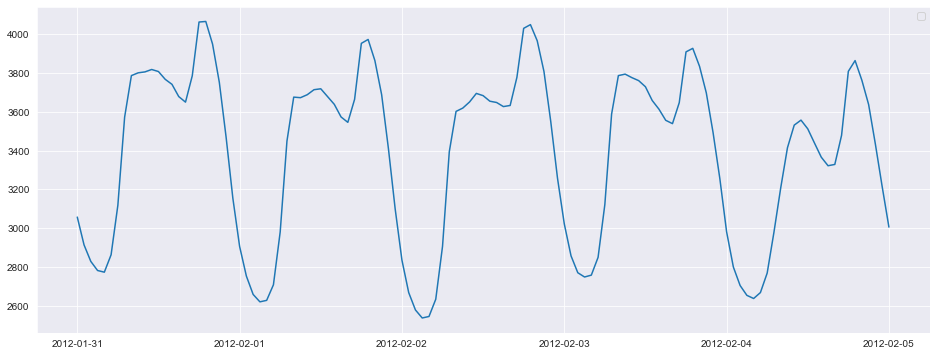

In [70]:
# Define figure style, plot package and default figure size
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(16, 6))
# Use plot_predict and visualize forecasts
figure = results.plot_predict(720, 840)

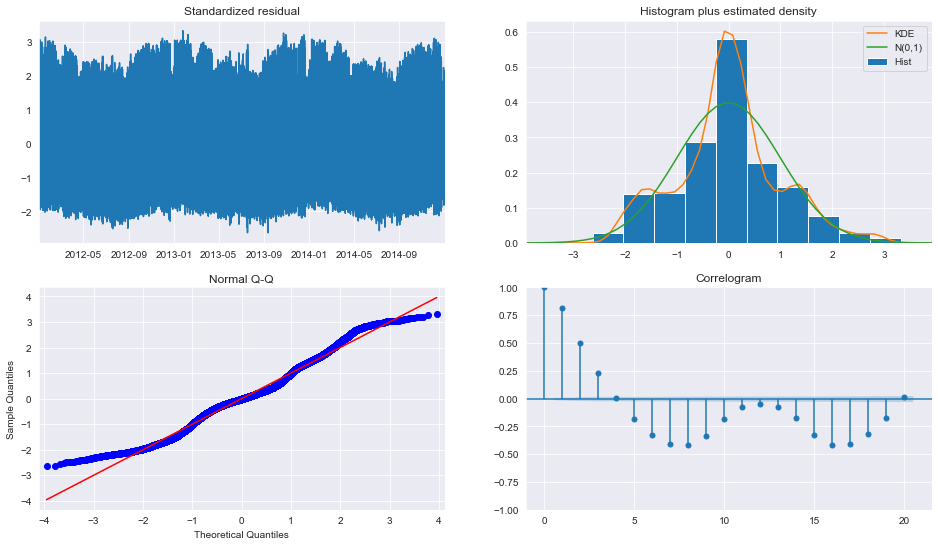

In [76]:
# Define default figure size
fig = plt.figure(figsize=(16,9))
# Use plot_predict and visualize forecasts
fig = results.plot_diagnostics(fig=fig, lags=20)

In [77]:
# Define the start date for the train and test sets
train_start_dt = '2014-11-01 00:00:00'
test_start_dt = '2014-12-30 00:00:00'

In [78]:
# Create train set containing only the model features
train = ts_data_load.copy()[
    (ts_data_load.index >= train_start_dt)
    & (ts_data_load.index < test_start_dt)][['load']]
test = ts_data_load.copy()[ts_data_load.index >= test_start_dt][['load']]
print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1416, 1)
Test data shape:  (48, 1)


In [80]:
# Scale train data to be in range (0, 1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head()
# Scale test data to be in range (0, 1)
test['load'] = scaler.transform(test)
test.head()

,load
2014-12-30 00:00:00,0.33
2014-12-30 01:00:00,0.29
2014-12-30 02:00:00,0.27
2014-12-30 03:00:00,0.27
2014-12-30 04:00:00,0.30


In [81]:
# Specify the number of steps to forecast ahead
HORIZON = 3
print('Forecasting horizon:', HORIZON, 'hours')

Forecasting horizon: 3 hours


In [85]:
# Create a test data point for each HORIZON
test_shifted = test.copy()
for t in range(1, HORIZON):
    test_shifted['load+'+str(t)] = test_shifted['load'].shift(-t, freq='H')

test_shifted = test_shifted.dropna(how='any')
test_shifted.head(5)

,load,load+1,load+2
2014-12-30 00:00:00,0.33,0.29,0.27
2014-12-30 01:00:00,0.29,0.27,0.27
2014-12-30 02:00:00,0.27,0.27,0.30
2014-12-30 03:00:00,0.27,0.30,0.41
2014-12-30 04:00:00,0.30,0.41,0.57


In [89]:
for x in train_ts:
    print(x)

0.10161145926589077
0.06580125335720677
0.04610564010743046
0.04252461951656206
0.05908683974932849
0.1042972247090419
0.19113697403760055
0.30572963294538935
0.4037600716204117
0.4785138764547896
0.5143240823634734
0.5268576544315129
0.5156669650850492
0.5013428827215756
0.4932855863921217
0.49910474485228273
0.5384959713518351
0.5948970456580125
0.6042972247090419
0.5447627573858549
0.4874664279319605
0.3965980304386749
0.2882721575649059
0.18621307072515658
0.12488809310653526
0.07251566696508505
0.05550581915846009
0.05595344673231861
0.07743957027752901
0.13115487914055501
0.23142345568487
0.35452103849597116
0.4713518352730528
0.5344673231871082
0.5626678603401969
0.5738585496866606
0.5523724261414502
0.5232766338406445
0.49955237242614126
0.5085049239033124
0.5671441360787823
0.6347358997314234
0.5989256938227394
0.5219337511190689
0.45792300805729624
0.3464637421665173
0.2260519247985675
0.14413607878245283
0.09579230080572954
0.07162041181736778
0.06087735004476258
0.070277529

In [112]:
training_window = 720
train_ts = train['load']
test_ts = test_shifted
history = [x for x in train_ts]
print(len(history))
#history = history[(-1400):]
print(len(history))

1416
1416


In [111]:
history[1415]

IndexError: list index out of range

In [91]:
train_ts

2014-11-01 00:00:00   0.10
2014-11-01 01:00:00   0.07
2014-11-01 02:00:00   0.05
2014-11-01 03:00:00   0.04
2014-11-01 04:00:00   0.06
                      ... 
2014-12-29 19:00:00   0.85
2014-12-29 20:00:00   0.78
2014-12-29 21:00:00   0.67
2014-12-29 22:00:00   0.52
2014-12-29 23:00:00   0.41
Freq: H, Name: load, Length: 1416, dtype: float64

In [92]:
test_ts

,load,load+1,load+2
2014-12-30 00:00:00,0.33,0.29,0.27
2014-12-30 01:00:00,0.29,0.27,0.27
2014-12-30 02:00:00,0.27,0.27,0.30
2014-12-30 03:00:00,0.27,0.30,0.41
2014-12-30 04:00:00,0.30,0.41,0.57
2014-12-30 05:00:00,0.41,0.57,0.68
2014-12-30 06:00:00,0.57,0.68,0.73
2014-12-30 07:00:00,0.68,0.73,0.75
2014-12-30 08:00:00,0.73,0.75,0.76
2014-12-30 09:00:00,0.75,0.76,0.74


In [86]:
%%time
# Make predictions on the test data
training_window = 720
train_ts = train['load']
test_ts = test_shifted
history = [x for x in train_ts]
history = history[(-training_window):]
predictions = list()
for t in range(test_ts.shape[0]):
    model = AutoReg(ts_data_load, 1)
    model_fit = model.fit()
    yhat = model_fit.predict
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

2014-12-30 00:00:00
1 : predicted = <bound method AutoRegResults.predict of <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x0000008E9D3F9D68>> expected = [0.32945389435989236, 0.2900626678603402, 0.2739480752014323]
2014-12-30 01:00:00
2 : predicted = <bound method AutoRegResults.predict of <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x0000008E9D3F9A58>> expected = [0.2900626678603402, 0.2739480752014323, 0.26812891674127126]
2014-12-30 02:00:00
3 : predicted = <bound method AutoRegResults.predict of <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x0000008E9D3F9B00>> expected = [0.2739480752014323, 0.26812891674127126, 0.3025962399283795]
2014-12-30 03:00:00
4 : predicted = <bound method AutoRegResults.predict of <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x0000008E9D3F9748>> expected = [0.26812891674127126, 0.3025962399283795, 0.40823634735899716]
2014-12-30 04:00:00
5 : predicted = <bound method AutoRegResults.predict of <statsmodel

2014-12-31 18:00:00
43 : predicted = <bound method AutoRegResults.predict of <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x0000008E9D644E10>> expected = [0.855863921217547, 0.7721575649059982, 0.7023276633840643]
2014-12-31 19:00:00
44 : predicted = <bound method AutoRegResults.predict of <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x0000008E9D36EE10>> expected = [0.7721575649059982, 0.7023276633840643, 0.6195165622202325]
2014-12-31 20:00:00
45 : predicted = <bound method AutoRegResults.predict of <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x0000008E9D644278>> expected = [0.7023276633840643, 0.6195165622202325, 0.5425246195165621]
2014-12-31 21:00:00
46 : predicted = <bound method AutoRegResults.predict of <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x0000008E9DDD23C8>> expected = [0.6195165622202325, 0.5425246195165621, 0.4735899731423454]
Wall time: 415 ms
